# VQ-VAE training example

Demonstration of how to train the model specified in https://arxiv.org/abs/1711.00937, using TF 2 / Sonnet 2.

On Mac and Linux, simply execute each cell in turn.

In [1]:
!pip install dm-sonnet dm-tree

     |████████████████████████████████| 254 kB 4.0 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.8.0
Sonnet version 2.0.0


# Download Cifar10 data
This requires a connection to the internet and will download ~160MB.


In [3]:
cifar10 = tfds.as_numpy(tfds.load("cifar10:3.0.2", split="train+test", batch_size=-1))
cifar10.pop("id", None)
cifar10.pop("label")
tree.map_structure(lambda x: f'{x.dtype.name}{list(x.shape)}', cifar10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete5CMJFI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete5CMJFI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


{'image': 'uint8[60000, 32, 32, 3]'}

# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [4]:
train_data_dict = tree.map_structure(lambda x: x[:40000], cifar10)
valid_data_dict = tree.map_structure(lambda x: x[40000:50000], cifar10)
test_data_dict = tree.map_structure(lambda x: x[50000:], cifar10)

In [5]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  images = data_dict['image']
  data_dict['image'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

train_data_variance = np.var(train_data_dict['image'] / 255.0)
print('train data variance: %s' % train_data_variance)

train data variance: 0.06327039811675479


# Encoder & Decoder Architecture


In [6]:
class ResidualStack(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = snt.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = snt.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(tf.nn.relu(h))
      conv1_out = conv1(tf.nn.relu(conv3_out))
      h += conv1_out
    return tf.nn.relu(h)  # Resnet V1 style


class Encoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = snt.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    print("encoder x", x.shape)
    h = tf.nn.relu(self._enc_1(x))
    print("encoder x", h.shape)
    h = tf.nn.relu(self._enc_2(h))
    print("encoder x", h.shape)
    h = tf.nn.relu(self._enc_3(h))
    print("encoder x", h.shape)
    x_encoded = self._residual_stack(h)
    print("encoder x", x_encoded.shape)
    return x_encoded


class Decoder(snt.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = snt.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")
    
  def __call__(self, x):
    print("decoder x", x.shape)
    h = self._dec_1(x)
    print("decoder x", h.shape)
    h = self._residual_stack(h)
    print("decoder x", h.shape)
    h = tf.nn.relu(self._dec_2(h))
    print("decoder x", h.shape)
    x_recon = self._dec_3(h)
    print("decoder x", x_recon.shape)
    return x_recon
    

class VQVAEModel(snt.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = tf.reduce_mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

# Build Model and train

In [7]:
%%time

# Set hyper-parameters.
batch_size = 32
image_size = 32

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
# 10k steps gives reasonable accuracy with VQVAE on Cifar10.
num_training_updates = 10

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)
  
model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                   data_variance=train_data_variance)

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(data):
  with tf.GradientTape() as tape:
    model_output = model(data['image'], is_training=True)
  trainable_variables = model.trainable_variables
  grads = tape.gradient(model_output['loss'], trainable_variables)
  optimizer.apply(grads, trainable_variables)

  return model_output

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []
codebooks_idx = []

for step_index, data in enumerate(train_dataset):
  train_results = train_step(data)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if (step_index + 1) % 100 == 0:
    print('%d train loss: %f ' % (step_index + 1,
                                   np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))
  if step_index == num_training_updates-1:
    codebooks_idx.append(train_results["vq_output"]["encoding_indices"])
  if step_index == num_training_updates:
    codebooks_idx.append(train_results["vq_output"]["encoding_indices"])
    break


Cause: Unable to locate the source code of <function train_step at 0x7efbbdceba70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function train_step at 0x7efbbdceba70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function train_step at 0x7efbbdceba70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
encoder x (32, 32, 32, 3)
encoder x (32, 16, 16, 64)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 64)
decoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 128)
decoder x (32, 16, 16, 64)
decoder x (32, 32, 32, 3)
encoder x (32, 32, 32, 3)
encoder x (32, 16, 16, 64)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 64)
decoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 128)
decoder x (3

In [8]:
train_results["vq_output"]

{'distances': <tf.Tensor: shape=(2048, 512), dtype=float32, numpy=
 array([[0.14338715, 0.18423364, 0.13834223, ..., 0.22958373, 0.22958373,
         0.22958373],
        [0.40140188, 0.45771912, 0.3898219 , ..., 0.54407126, 0.54407126,
         0.54407126],
        [0.53057194, 0.58710194, 0.50985634, ..., 0.69544667, 0.69544667,
         0.69544667],
        ...,
        [0.07361978, 0.06460249, 0.0651274 , ..., 0.09137999, 0.09137999,
         0.09137999],
        [0.04394198, 0.04480489, 0.0427895 , ..., 0.06884511, 0.06884511,
         0.06884511],
        [0.02409032, 0.04045496, 0.03899457, ..., 0.04551005, 0.04551005,
         0.04551005]], dtype=float32)>,
 'encoding_indices': <tf.Tensor: shape=(32, 8, 8), dtype=int64, numpy=
 array([[[200,  46,  46, ..., 221, 221, 221],
         [ 32,  32,  32, ..., 221, 221, 221],
         [ 88, 176, 176, ..., 500, 137, 415],
         ...,
         [  4,   3,   3, ...,   3,  41,   4],
         [189,   3,  41, ...,  41,  41,   3],
         [ 

In [9]:
train_results["vq_output"]["encoding_indices"]

<tf.Tensor: shape=(32, 8, 8), dtype=int64, numpy=
array([[[200,  46,  46, ..., 221, 221, 221],
        [ 32,  32,  32, ..., 221, 221, 221],
        [ 88, 176, 176, ..., 500, 137, 415],
        ...,
        [  4,   3,   3, ...,   3,  41,   4],
        [189,   3,  41, ...,  41,  41,   3],
        [  0, 187, 187, ..., 386, 386,   0]],

       [[  1,   4,  88, ..., 176,   4,   5],
        [  4, 176, 176, ..., 176, 176,   4],
        [280,  41,  46, ...,  41,   4,   4],
        ...,
        [221, 221, 221, ..., 176, 176,   4],
        [221, 221, 221, ..., 176, 176,   3],
        [  2,  32, 415, ...,   3,   3,   3]],

       [[ 88, 176, 176, ...,  88,  88,   4],
        [176, 176, 176, ..., 176, 176,   4],
        [176, 176, 176, ..., 176, 176,   4],
        ...,
        [176, 176, 176, ..., 137, 221, 221],
        [176, 176, 176, ...,  46, 221, 221],
        [189,   3,   3, ..., 200, 221, 415]],

       ...,

       [[ 41,  46,  46, ...,  46, 253, 295],
        [200, 221, 221, ..., 221, 253

In [10]:
#torch.Tensor(codebooks_idx[0].numpy())

NameError: ignored

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

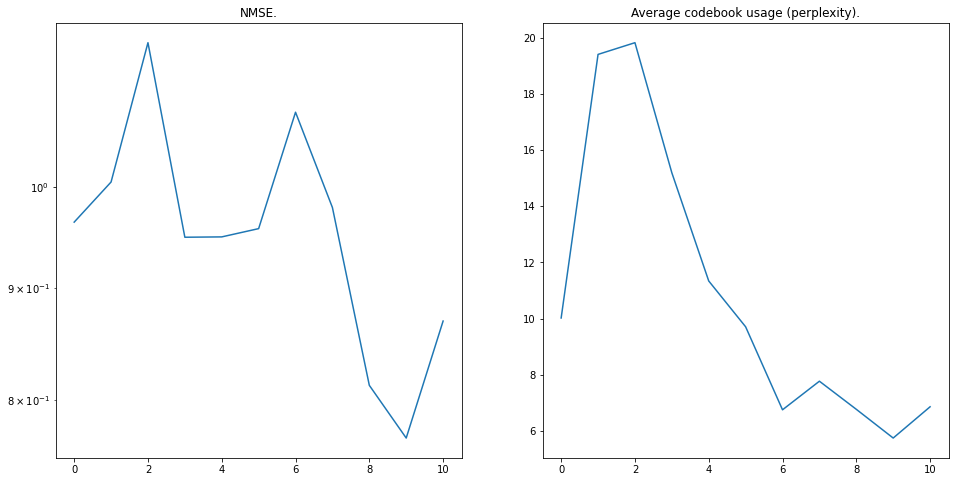

In [11]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

encoder x (32, 32, 32, 3)
encoder x (32, 16, 16, 64)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 64)
decoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 128)
decoder x (32, 16, 16, 64)
decoder x (32, 32, 32, 3)
encoder x (32, 32, 32, 3)
encoder x (32, 16, 16, 64)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
encoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 64)
decoder x (32, 8, 8, 128)
decoder x (32, 8, 8, 128)
decoder x (32, 16, 16, 64)
decoder x (32, 32, 32, 3)


(-0.5, 255.5, 127.5, -0.5)

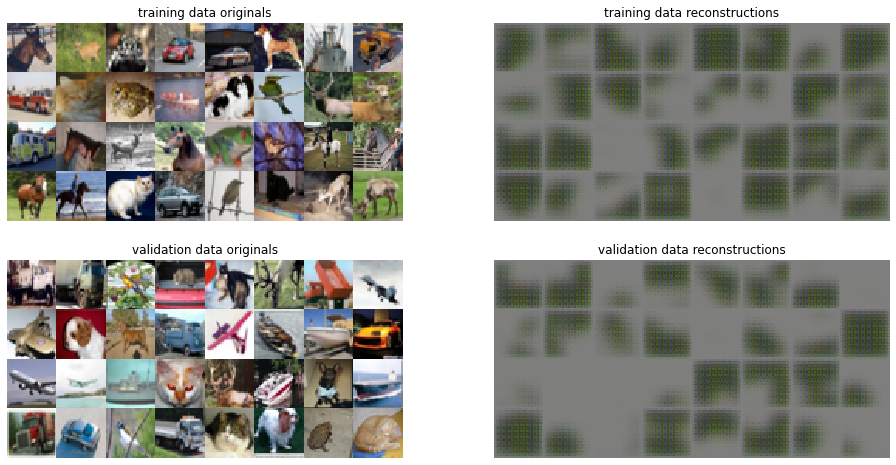

In [12]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = model(train_batch['image'],
                              is_training=False)['x_recon'].numpy()
valid_reconstructions = model(valid_batch['image'],
                              is_training=False)['x_recon'].numpy()


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['image'].numpy()),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

# Image generation

## Build generator and train

In [13]:
%%capture
!pip install pytorch-lightning
!pip install transformers

In [14]:
import gc
import pytorch_lightning as pl
from argparse import Namespace
import torch
from torch.utils.data import TensorDataset
from torch.cuda import is_available, device_count, get_device_name, current_device
import torch.optim as optim 
from torch.optim import lr_scheduler
import itertools
from transformers import GPT2LMHeadModel, GPT2Config
from collections import OrderedDict

In [15]:
class Cudafy(object):

    def __init__(self, device=None):
        if is_available() and device:
            self.device = device
        else:
            self.device = 0

    @staticmethod
    def check_devices():
        for i in range(device_count()):
            print("Found device {}:".format(i), get_device_name(i))
        if device_count() == 0:
            print("No GPU device found")
        else:
            print("Current cuda device is", get_device_name(current_device()))

    def name(self):
        if is_available():
            return get_device_name(self.device)
        return 'Cuda is not available.'

    def put(self, x):
        """Put x on the default cuda device."""
        if is_available():
            return x.to(device=self.device)
        return x

    def __call__(self, x):
        return self.put(x)

    def get(self, x):
        """Get from cpu."""
        if x.is_cuda:
            return x.to(device='cpu')
        return x

In [16]:
cudafy = Cudafy(0)

In [24]:
class Generator(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.dataset = self.load_dataset(hparams)
        hparams.vocab_size = self.dataset.vocab_size
        hparams.height, hparams.width = self.dataset.shape[1:]
        hparams.max_length = self.dataset.length
        self.model = self.build_model(hparams)
        hparams = vars(hparams)
        for key in hparams:
            self.hparams[key] = hparams[key]

    def load_dataset(self, hparams):
        print("Loading the dataset of codes into memory...")
        device = "cpu"

        # Convert a list of tf tensors into a list of pytorch tensors
        data_tf = hparams.dataset
        data_numpy = [batch.numpy() for batch in data_tf]
        data = [torch.Tensor(batch) for batch in data_numpy]

        #bottom_codes.append(bottom_idxs.data.cpu())

        codes = torch.cat(data)

        print('codes shape', codes.shape, type(codes),'min',codes.min(),'max', codes.max())
        if hparams.nb_examples and len(codes) >= hparams.nb_examples:
            codes = codes[:hparams.nb_examples]

        codes_ = codes.view(len(codes), -1)
        print('codes_', codes_.shape)
        codes_ = codes_.long()
        print('codes_', codes_.shape)

        dataset = TensorDataset(codes_)
        dataset.vocab_size = codes_.shape[1]
        print('vocab_size', dataset.vocab_size)
        dataset.shape = codes.shape
        print('shape', dataset.shape)
        dataset.length = codes_.shape[1]
        print('length', dataset.length)
        
        del codes_
        del codes
        #torch.cuda.empty_cache()
        gc.collect()
        print("Done loading dataset")
        return dataset

    def forward(self, x):
        return self.model(x)

    def build_model(self, hparams):
        config = GPT2Config(vocab_size=hparams.vocab_size, 
                            n_positions=hparams.max_length, 
                            n_ctx=hparams.max_length, 
                            n_embd=128, #256
                            n_layer=4, 
                            n_head=4, 
                            resid_pdrop=0.2,
                            embd_pdrop=0.2,
                            attn_pdrop=0.2)
        return GPT2LMHeadModel(config)

    def generate(self, nb_examples=1, **kwargs):
        hparams = Namespace(**self.hparams)
        input_ids = cudafy(torch.randint(0,self.hparams.vocab_size, (nb_examples, 1)).long())
        result = self.model.generate(input_ids, max_length=hparams.max_length, **kwargs)
        print(result.shape,'output of model')
        result = result.contiguous()
        print(result.shape,'output of model')
        #print(result.shape, 'result after reshaping')
        result = result.view(nb_examples, hparams.height, hparams.width)
        print(result.shape,'output of model')
        del input_ids
        #torch.cuda.empty_cache()
        gc.collect()
        return result

    def training_step(self, batch, batch_idx):
        print("Training step : " + str(batch_idx))
        (X,) = batch
        #print("X.shape", X.shape)
        outputs = self.model(X, labels=X)
        loss = outputs.loss
        print("loss", loss)
        output = OrderedDict({"loss": loss, "log": {"loss": loss,},})
        #print("output", output)
        del outputs, loss
        #torch.cuda.empty_cache()
        gc.collect()
        return output

    def train_dataloader(self):
        hparams = Namespace(**self.hparams)
        #del self.dataset
        #torch.cuda.empty_cache()
        #gc.collect()
        return torch.utils.data.DataLoader(self.dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.num_workers)

    def configure_optimizers(self):
        hparams = Namespace(**self.hparams)
        optimizer = optim.Adam(self.parameters(),lr=hparams.lr, weight_decay=hparams.weight_decay)
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=hparams.scheduler_gamma)
        return [optimizer], [scheduler]

In [26]:
def train_generator(hparams):
    hparams = Namespace(**hparams)
    generator = Generator(hparams)
    #logger = pl.loggers.TensorBoardLogger(save_dir=hparams.folder, name="logs")
    trainer = pl.Trainer(#default_root_dir=hparams.folder, 
                          enable_checkpointing=False,
                          #weights_save_path=hparams.folder+'/checkpoints',
                          max_epochs=hparams.epochs,
                          enable_progress_bar=True,
                          gpus=hparams.gpus,
                          #logger=logger,
                          #resume_from_checkpoint=hparams.resume_from_checkpoint,
                          detect_anomaly=True)
    trainer.fit(generator) #, ckpt_path=hparams.resume_from_checkpoint)
    return generator, trainer

hparams = {'resume_from_checkpoint': None,
        'folder': '/out/generator', 
        'dataset': codebooks_idx,
        'epochs': 5, #200  
        'lr': 1e-3, 
        'weight_decay': 0,
        'scheduler_gamma':  1, 
        'batch_size': 128, # ok : 32, 64, 128 / not ok : 256
        'num_workers': 1, 
        'nb_examples':2000, #nb_images
        'gpus': 1 if torch.cuda.is_available() else 0}
generator, trainergenerator = train_generator(hparams=hparams)

Loading the dataset of codes into memory...
codes shape torch.Size([64, 8, 8]) <class 'torch.Tensor'> min tensor(0.) max tensor(500.)
codes_ torch.Size([64, 64])
codes_ torch.Size([64, 64])
vocab_size 64
shape torch.Size([64, 8, 8])
length 64


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done loading dataset


RuntimeError: ignored